# **Introduction**
---

In the exciting field of object tracking, we embark on a project to deploy the advanced deep learning models, YOLOv8 and ByteTrack, to track the number of vehicles entering and leaving a bustling highway. Our aim is to craft an efficient and reliable system that can perform real-time detection and tracking of vehicles, while simultaneously keeping count of their movements. These models have shown remarkable performance in object detection and tracking tasks, and we will leverage their strengths to develop a custom pipeline that ensures highly accurate and efficient vehicle tracking.

## **Table of Contents**
---
* [Video Information Extraction](#Video-Information-Extraction)
* [Line Coordinates](#Line-Coordinates)
* [Vehicle Count](#Vehicle-Count)
* [Usage](#Usage)


In [1]:
# Importing required libraries
from IPython import display
from ultralytics import YOLO
import supervision as sv
import cv2
import numpy as np
from datetime import timedelta
import os
from IPython.display import HTML
import base64
from IPython.display import Image
display.clear_output()

## **Video Information Extraction**
---

In [2]:
def get_video_info(video_path):
    
    # Extracting information about the video
    video_info = sv.VideoInfo.from_video_path(video_path)
    width, height, fps, total_frames = video_info.width, video_info.height, video_info.fps, video_info.total_frames
    
    # Calculating the length of the video by dividing the total number of frames by the frame rate and rounding to the nearest second
    video_length = timedelta(seconds = round(total_frames / fps))
    
    # Print out the video resolution, fps, and length u
    print(f"\033[1mVideo Resolution:\033[0m ({width}, {height})")
    print(f"\033[1mFPS:\033[0m {fps}")
    print(f"\033[1mLength:\033[0m {video_length}")

In [3]:
# Extracting information of the test video
get_video_info('Data/Example Videos/test1.mp4')

Video Resolution: (1280, 720)
FPS: 30
Length: 0:00:31


## **Line Coordinates**
---

If you want to draw a line in a desired location in the video, you'll need to obtain the coordinates for that line. One easy way to do this is by extracting a frame from the video and then using a website to get the coordinates.

1. **Extract a frame from the video.** You can use a video editor or a Python library like OpenCV or Supervision to extract a frame from the video.

2. **Go to the website [PolygoneZone](https://roboflow.github.io/polygonzone/](https://roboflow.github.io/polygonzone/).** This website allows you to easily draw a polygon on the image and get the coordinates for that polygon.

3. **Upload the extracted frame to the website.** Click on the "Choose File" button and select the extracted frame from your computer.

4. **Draw a line on the image.** Use the polygon drawing tool to draw a line in the desired location on the image.

5. **Get the line coordinates.** Once you have drawn the line, the website will display the coordinates for the line. These coordinates can be copied and used in your Python code to draw the line in the desired location in the video.

By following these simple steps, you can easily obtain the coordinates for drawing a line in the desired location in the video using a website.

## **Vehicle Count**
---

In [4]:
def vehicle_count(source_path, destination_path, line_start, line_end):
   
   # Load the pre-trained YOLO model
   model = YOLO('yolov8l.pt')

   # Create two points from the line_start and line_end coordinates
   line_start = sv.Point(line_start[0], line_start[1])
   line_end = sv.Point(line_end[0], line_end[1])
   
   # Create a line zone object from the two points
   line_counter = sv.LineZone(line_start, line_end) 
   
   # Create a line zone annotator object with specific thickness and text scale
   line_annotator = sv.LineZoneAnnotator(thickness = 2,
                                         text_thickness = 1,
                                         text_scale = 0.5)
   
   # Create a box annotator object with specific thickness and text scale
   box_annotator = sv.BoxAnnotator(thickness = 1,
                                   text_thickness = 1,
                                   text_scale = 0.5)
   
   # Extract information about the video from the given source path
   video_info = sv.VideoInfo.from_video_path(source_path)

   # Create a video out path by combining the destination path and the video name
   video_name = os.path.splitext(os.path.basename(source_path))[0] + ".mp4"
   video_out_path = os.path.join(destination_path, video_name)

   # Create a video writer object for the output video
   video_out = cv2.VideoWriter(video_out_path, cv2.VideoWriter_fourcc(*'mp4v'), video_info.fps, (video_info.width, video_info.height))
   
   # Loop over each frame of the video and perform object detection and tracking
   for result in model.track(source = source_path, tracker = 'bytetrack.yaml', show=True, stream=True, agnostic_nms=True):
        
        # Get the original frame from the detection result
        frame = result.orig_img
        
        # Convert the YOLO detection results to a Detections object
        detections = sv.Detections.from_yolov8(result)
      
        # If the detections have an associated ID, set the tracker ID in the Detections object
        if result.boxes.id is not None:
          detections.tracker_id = result.boxes.id.cpu().numpy().astype(int)

        # Filter the detections to only include classes 2 (cars) and 7 (trucks)
        detections = detections[(detections.class_id == 2) | (detections.class_id == 7)]

        # Generate labels for the detections, including the tracker ID, class name, and confidence
        labels = [f"{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
                  for _, confidence, class_id, tracker_id 
                  in detections]
    
        # Trigger the line counter to count any detections that intersect the line zone
        line_counter.trigger(detections)
     
        # Annotate the frame with the line zone and any intersecting detections
        line_annotator.annotate(frame, line_counter)

        # Annotate the frame with bounding boxes and labels for all detections
        frame = box_annotator.annotate(scene = frame,
                                       detections = detections,
                                       labels = labels)
        # Write the annotated frame to the output video
        video_out.write(frame)
  
   # Release the video writer and clear the Jupyter Notebook output
   video_out.release()
   display.clear_output()

## **Usage**
---

In [5]:
# Performing vehicle count on the test video
vehicle_count(source_path = "Data/Example Videos/test1.mp4",
              destination_path = "Data/Example Results",
              line_start = (337, 391),
              line_end = (917, 387))

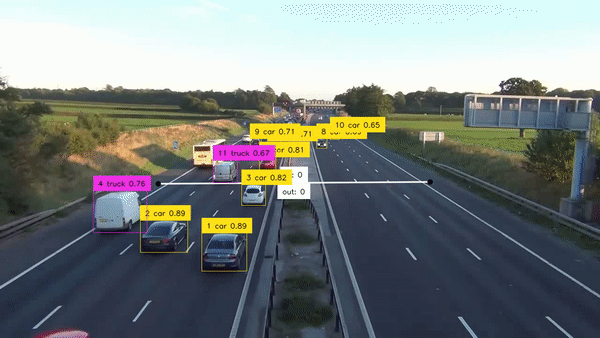

In [6]:
# Path to the GIF file
gifPath = 'Data/Example Results/test1.gif'

# Output the GIF file
Image(filename = gifPath)